In [1]:
from __future__ import print_function, absolute_import, division
from collections import namedtuple
from cityscapesscripts.helpers.labels import *
import Helper.Helper_functions as hf
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks
from PIL import Image
from Helper.ml_models import *
import os
import numpy as np
import matplotlib.pyplot as plt

city_label_color_map = np.array([
    [255, 255, 0], #ID__0, road
    [244, 35, 232],  #ID__1, sidewalk
    [70, 70, 70],    #ID__2, building
    [102, 102, 156], #ID__3, wall
    [190, 153, 153], #ID__4, fence
    [153, 153, 153], #ID__5, pole
    [250, 170, 30],  #ID__6, traffic light
    [220, 220, 0],   #ID__7, traffic sign
    [107, 142, 35],  #ID__8, vegetation
    [152, 251, 152], #ID__9, terrain
    [70, 130, 180],  #ID__10, sky
    [220, 20, 60],   #ID__11, person
    [255, 0, 0],     #ID__12, rider
    [0, 0, 142],     #ID__13, car
    [0, 0, 70],      #ID__14, truck
    [0, 60, 100],    #ID__15, bus
    [0, 80, 100],    #ID__16, train
    [0, 0, 230],     #ID__17, motorcycle
    [119, 11, 32],   #ID__18, bicycle
    [0, 0, 0],       #ID__19, unlabeled
])

colors = [city_label_color_map[i] for i in range(20)] 

In [2]:
print("List of cityscapes labels:")
print("")
print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12} | {:>14}".format('name', 'id', 'trainId', 'category',
                                                                              'categoryId', 'hasInstances',
                                                                              'color', 'ignoreInEval'))
print("    " + ('-' * 98))
counter = 0
for label in labels:
    #if label.ignoreInEval ==0:
    counter +=1
    print("     {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12} | {}".format(label.name, label.id, label.trainId,
                                                                                  label.category, label.categoryId,
                                                                                  label.hasInstances,
                                                                                  str(label.color),  # Convert the tuple to a string
                                                                                  label.ignoreInEval,
                                                                                  ))
print(" ", '\n', counter)

List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances |        color |   ignoreInEval
    --------------------------------------------------------------------------------------------------
                 unlabeled |   0 |     255 |           void |          0 |            0 |    (0, 0, 0) | True
               ego vehicle |   1 |     255 |           void |          0 |            0 |    (0, 0, 0) | True
      rectification border |   2 |     255 |           void |          0 |            0 |    (0, 0, 0) | True
                out of roi |   3 |     255 |           void |          0 |            0 |    (0, 0, 0) | True
                    static |   4 |     255 |           void |          0 |            0 |    (0, 0, 0) | True
                   dynamic |   5 |     255 |           void |          0 |            0 | (111, 74, 0) | True
                    ground |   6 |     255 |           void |          0 |            0 | 

# Create dictionary with the ID and Values for remapping the annotation images

New dictionary gets compared to the cityscapes mapping and differences are printed. Values of 255 got mapped to value 19, so only IDs which initially had the value 155 and got changed to 19 should be printed. 

In [3]:
id_to_trainId = {label.id: label.trainId for label in labels if label.trainId >= 0}
id_to_trainId_updated = {k: 19 if v == 255 else v for k, v in id_to_trainId.items()}

# Iterate over the keys in id_to_trainId_updated
for key in id_to_trainId_updated:
    # Check if the value in id_to_trainId_updated matches the value in id_to_trainId
    if id_to_trainId_updated[key] != id_to_trainId.get(key, None):
        # If the values do not match, print out the key and the corresponding values
        print(f'Key: {key}, id_to_trainId: {id_to_trainId.get(key, None)}, id_to_trainId_updated: {id_to_trainId_updated[key]}')

Key: 0, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 1, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 2, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 3, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 4, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 5, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 6, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 9, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 10, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 14, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 15, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 16, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 18, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 29, id_to_trainId: 255, id_to_trainId_updated: 19
Key: 30, id_to_trainId: 255, id_to_trainId_updated: 19


# Labeling of the Annotations

The annotations get labeled according to the above table, using trainID for the resulting value in the annotation. Annotations with value 255 get labeled to channel 19. All labels got preprocessed by the cityscapes function and sorted intp the CityscapesDaten/semantic_default folder. Here the annotations are still labeled by the id range. Annotations get opened from this folder, processed by a script in this jupyter notebook and saved the CityscapesDaten/semantic folder. 


In [4]:
def create_ground_truth_V2(in_path, out_path, batch_size=6):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create a mapping from label ID to trainId
    id_to_trainId = {label.id: label.trainId for label in labels if label.trainId >= 0}
    id_to_trainId = {k: 19 if v == 255 else v for k, v in id_to_trainId.items()}
    id_to_trainId = torch.tensor([id_to_trainId.get(i, -1) for i in range(256)], dtype=torch.long, device=device)

    # Get the list of image files
    image_files = os.listdir(in_path)

    # Process the images in batches
    for i in tqdm(range(0, len(image_files), batch_size), desc="Processing images"):
        batch_files = image_files[i:i+batch_size]
        batch_images = []
        for image_file in batch_files:
            # Load the annotation image
            annotation = Image.open(os.path.join(in_path, image_file))
            # Convert the annotation image to a PyTorch tensor and move it to the device
            annotation = torch.from_numpy(np.array(annotation)).to(device)
            batch_images.append(annotation)

        # Stack images into a batch
        batch_images = torch.stack(batch_images)

        # Convert the label IDs to trainId
        batch_images = id_to_trainId[batch_images.long()]

        # Save the images
        for j, image in enumerate(batch_images):
            # Convert the tensor back to a PIL image
            image = transforms.ToPILImage()(image.cpu().byte())
            # Save the annotation image with the original name
            image.save(os.path.join(out_path, batch_files[j]))

In [5]:
annotation_input = 'CityscapesDaten/semantic_default'
annotation_output = 'CityscapesDaten/semantic'

os.makedirs(annotation_output, exist_ok=True)

run = False
while run: 
    create_ground_truth_V2(annotation_input, annotation_output)
    break

# Use Dataloader to load an image and annotation from the folder

The shape of the Image should be [3, 520, 520] and the shape of the annotation should be [520, 520] of type uint8, where each int value represents a corresponding class. The unique annotation value range should be [  0   1   2   5   6   7   8   9  10  11  13  15  18 19].

In [6]:
annotation_dir = 'CityscapesDaten/semantic'
dataset = CustomDataSet(image_dir='CityscapesDaten/images',
                        annotation_dir='CityscapesDaten/semantic')
image, annotation = dataset.__getitem__(0)

print(f'Image shape: {image.shape}, Annotation shape: {annotation.shape}')
print(f'Dataloader annotation Value range: {np.unique(annotation)}')

annotation_files = os.listdir(annotation_dir)[:100]  # Get the first 100 files

all_values = []

for annotation_file in annotation_files:
    # Load the annotation image
    annotation = Image.open(os.path.join(annotation_dir, annotation_file))
    # Convert the annotation image to a numpy array
    annotation = np.array(annotation)
    # Append the unique values in this image to the list of all values
    all_values.extend(np.unique(annotation))

# Get unique values from all_values
unique_values = np.unique(all_values)

# Print all unique values
print(f'All unique annotation values in first 100 images: {unique_values}')

Image shape: torch.Size([3, 520, 520]), Annotation shape: torch.Size([520, 520])
Dataloader annotation Value range: [ 0  2  5  7  8  9 11 13 15 19]
All unique annotation values in first 100 images: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Before Mask Overlay
type(image): <class 'torch.Tensor'>, type(masks): <class 'torch.Tensor'>
shape(image): torch.Size([3, 520, 520]), shape(masks): torch.Size([20, 520, 520])


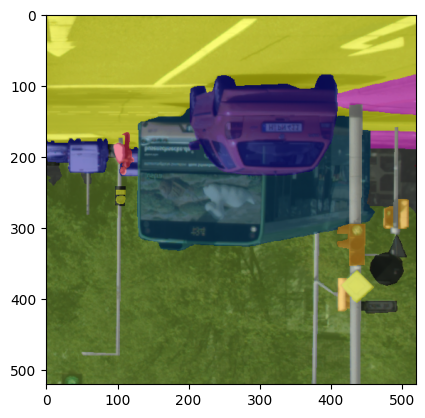

In [7]:
# Define the mean and std
mean = torch.tensor([0.2892, 0.3272, 0.2867]).view(1, 3, 1, 1)
std = torch.tensor([0.1904, 0.1932, 0.1905]).view(1, 3, 1, 1)

# Get the image and annotation
image, annotation = dataset.__getitem__(0)

# Revert the normalization
image = image * std + mean

# Convert the image tensor to uint8
image = (image * 255).byte()

# Remove the batch dimension from the image tensor
image = image.squeeze(0)

# Convert the annotation tensor to a set of binary masks
masks = torch.stack([(annotation == i) for i in range(20)])

print(f'Before Mask Overlay')
print(f'type(image): {type(image)}, type(masks): {type(masks)}')
print(f'shape(image): {image.shape}, shape(masks): {masks.shape}')

# Draw segmentation masks
overlay = draw_segmentation_masks(image, masks, alpha=0.5, colors=colors)

# Convert overlay to numpy array for displaying
overlay = overlay.permute(1, 2, 0).numpy()

# Display the overlay
plt.imshow(overlay)
plt.show()